In [1]:
from scipy import integrate, optimize
import matplotlib.pyplot as plt
import numpy as np
import random
import math


In [2]:
def SEIRM(y, x, alpha, alpha_r, beta, gamma_r, gamma_u, mu):
    alpha_u = 1.0*(1-alpha)/alpha * alpha_r

    dS = -1.0*beta*y[0]*(y[2]+y[3])/N
    dE = beta*y[0]*(y[2]+y[3])/N - alpha_r*y[1] - alpha_u*y[1]
    dI_r = alpha_r*y[1] - gamma_r*y[2] - mu*y[2]
    dI_u = alpha_u*y[1] - gamma_u*y[3]
    dR = gamma_r*y[2] + gamma_u*y[3]
    dM = mu*y[2]

    return dS, dE, dI_r, dI_u, dR, dM

In [9]:
def FitSEIRM(x, alpha, alpha_r, beta, gamma_r, gamma_u, mu, E0):        
    S0 = N - E0

    ret =  integrate.odeint(func = SEIRM, y0 = (S0, E0, 0, 0, 0 ,0), t = x, args = (alpha, alpha_r, beta, gamma_r, gamma_u, mu))

    I = N - ret[:,0] - ret[:,1]
    Ir = alpha*np.gradient(I)
    M = ret[:,5]
    M = 10*np.gradient(M) # Mortality Calibration Weight
    IM = np.hstack((Ir,M))

    return IM


In [10]:
def FitSEIRM_p(x, alpha_r, beta, gamma_r, gamma_u, mu, E0):
    p_alpha = 0.75

    S0 = N - E0

    ret =  integrate.odeint(func = SEIRM, y0 = (S0, E0, 0, 0, 0 ,0), t = x, args = (p_alpha, alpha_r, beta, gamma_r, gamma_u, mu))

    I = N - ret[:,0] - ret[:,1]
    Ir = p_alpha*np.gradient(I)
    M = ret[:,5]
    M = 10*np.gradient(M) # Mortality Calibration Weight
    IM = np.hstack((Ir,M))

    return IM

In [14]:
def FitSEIRM_pp(x, alpha, alpha_r, beta, gamma_r, gamma_u, mu, E0): 
    S0 = N - E0

    ret =  integrate.odeint(func = SEIRM, y0 = (S0, E0, 0, 0, 0 ,0), t = x, args = (alpha, alpha_r, beta, gamma_r, gamma_u, mu))

    I = N - ret[:,0] - ret[:,1]
    I = np.gradient(I)
    Ir = alpha*I
    Iu = (1-alpha)*I
    M = ret[:,5]
    M = 10*np.gradient(M) # Mortality Calibration Weight
    IM = np.hstack((Ir,Iu,M))

    return IM

In [11]:
N = 25000
ALPHA = 0.1

XData = list(range(1, 90+1))
XData = np.array(XData, dtype = float)

Data = integrate.odeint(func = SEIRM, y0 = (N-10, 10, 0, 0, 0 ,0), t = XData, args = (ALPHA, 0.1, 0.36, 0.095, 0.2, 0.005)) # Ground truth alpha

In [12]:
YCases = N - Data[:,0] - Data[:,1]
YCases = np.gradient(YCases)
YReports = ALPHA*YCases # Ground truth alpha
YUnreports = (1-ALPHA)*YCases # Ground truth alpha
YDeaths = Data[:,5]
YDeaths = 10*np.gradient(YDeaths) # Mortality Calibration Weight

YData = np.hstack((YReports, YDeaths))
YData = np.array(YData, dtype = float)

ParaOpt_p, ParaCov_p = optimize.curve_fit(f = FitSEIRM_p, xdata = XData, ydata = YData, maxfev = 10000, p0 = (1, 1, 1, 1, 1, 10), bounds = [[0,0,0,0,0,0], [1,1,1,1,1,N]])

In [13]:
Parameter_p = [0.75, ParaOpt_p[0], ParaOpt_p[1], ParaOpt_p[2], ParaOpt_p[3], ParaOpt_p[4], ParaOpt_p[5], N - ParaOpt_p[5], 0, 0, 0, 0]

Result_p = FitSEIRM(XData, *Parameter_p[0:7])

In [16]:
def IntegerCost(x):
    Sum = math.log(2.865,2)+1
    if (abs(x) > 1.01):
        add = math.log(abs(x),2)
        while (add > 1.01):
            Sum = Sum + add
            add = math.log(add,2)
    return Sum

def RealNumberCost(x):
    delta = 0.1
    if (math.floor(abs(x)) == 0):
        return 1-math.log(delta,2) 
    else:
        return IntegerCost(math.floor(abs(x)))-math.log(delta,2)+1 

def VectorCost(x):
    Sum = 0
    for xnow in x:
        Sum = Sum + RealNumberCost(xnow)
    return Sum

def TimeSeriesCost(x):
    Sum = 0
    Length = x.shape[0]
    x_grad = np.around(np.gradient(x))
    T, Tcount = np.unique(x_grad, return_counts = True)
    XDictionary = {}
    for counter in range(len(T)):
        XDictionary[int(T[counter])] = int(Tcount[counter]) 
    for keys in XDictionary.keys():
        Sum = Sum + 1.0*XDictionary[keys]/Length*math.log(1.0*Length/XDictionary[keys],2)
    Sum = Length * Sum
    for keys in XDictionary.keys():
        Sum = Sum + IntegerCost(int(keys))
    return Sum

def MDL(D, Parameter_p, Parameter_pp, Result_pp):
    ModelCost1 = VectorCost(Parameter_p)
    ModelCost2 = VectorCost(Parameter_pp - Parameter_p)
    ModelCost3 = TimeSeriesCost(Parameter_pp[0]*D - Result_p[:len(YCases)])
    ModelCost = ModelCost1 + ModelCost2 + ModelCost3
    DataCost = TimeSeriesCost((D-YReports)/(1-Parameter_pp[0]) - (Result_pp[:len(YCases)]+Result_pp[len(YCases):2*len(YCases)]))
    MDLCost = ModelCost + DataCost

    return MDLCost

def ProbabilitySelect(XList):
    XSelect = []
    Probability = []
    XMin = min(XList)
    for counter in range(len(XList)):
        if (abs(XList[counter] - XMin) < 0.001):
            XSelect.append(counter)
            Probability.append(1)

    Probability = np.array(Probability)
    Probability = Probability / np.sum(Probability)
    Result = np.random.choice(XSelect, p = Probability)

    return Result

In [24]:
from scipy.optimize import minimize

Dday = np.copy(D)

res = minimize(MDL, Dday, args = (Parameter_p, Parameter_pp, Result_pp), method='nelder-mead', options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 501.853754
         Iterations: 443
         Function evaluations: 3641


In [28]:
res.x

array([ 101.38677536,  111.13773302,  125.78508025,  140.68598114,
        155.80621303,  170.92206281,  186.03735877,  201.18057667,
        216.3315756 ,  231.48049878,  246.61583262,  261.99050623,
        267.24238697,  282.5562175 ,  292.88657264,  308.28028608,
        318.70942607,  334.22299598,  349.810427  ,  360.39862668,
        380.79593954,  386.61709207,  397.56297681,  408.6363556 ,
        419.94486882,  431.14376186,  442.66382856,  454.25781284,
        461.49581287,  473.39846686,  485.72904227,  498.34636934,
        506.47188236,  519.69599712,  533.18354742,  542.3081846 ,
        571.32105773,  591.16852034,  625.93667485,  681.294415  ,
        701.62490866,  747.32002475,  798.04767001,  814.00706448,
        825.17079655,  836.1727932 ,  847.0320114 ,  857.53944859,
        862.91043054,  867.19497091,  875.93299679,  868.93511318,
        885.68194694,  911.81881056,  911.77879232,  960.56220983,
       1015.57399005, 1001.32686209, 1072.63228265, 1123.59849

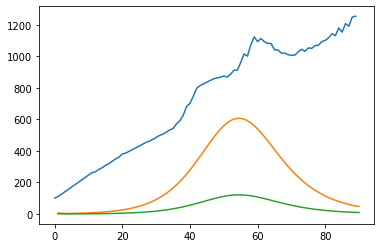

In [30]:
plt.plot(res.x. label = 'Nelder Mead results')
plt.plot(XData, YCases, label='D_ground_truth')
plt.plot(XData, YReports/0.5, label='D_reports')

In [17]:
Parameter_p = np.array(Parameter_p)

D = np.copy(YReports/0.5)
print (sum(D),sum(YReports/ALPHA))    
YDataMore = np.hstack((YReports, D-YReports, YDeaths))
ParaOpt_pp, ParaCov_pp = optimize.curve_fit(f = FitSEIRM_pp, xdata = XData, ydata = YDataMore, maxfev = 10000, p0 = (1, 1, 1, 1, 1, 1, 10), bounds = [[0,0,0,0,0,0,0], [1,1,1,1,1,1,N]])
Parameter_pp = [ParaOpt_pp[0], ParaOpt_pp[1], ParaOpt_pp[2], ParaOpt_pp[3], ParaOpt_pp[4], ParaOpt_pp[5], ParaOpt_pp[6], N - ParaOpt_pp[6], 0, 0, 0, 0]
Result_pp = FitSEIRM_pp(XData, *Parameter_pp[0:7])
Parameter_pp = np.array(Parameter_pp)
Parameter_pp[0] = sum(YReports) / sum(D)
Result_pp[:len(YCases)] = YReports
Result_pp[len(YCases):2*len(YCases)] = D - YReports

3856.109531089962 19280.547655449813


In [22]:
counter = 0
while (True):
    counter = counter + 1

    NewMDLCost = [0]*(len(D))
    for day in range(len(D)):
        Dday = np.copy(D)
        if (day == 1):
            Dday[day] = D[day] + 25
            Dday[day+1] = D[day+1] + 15
        elif (day == 89):
            Dday[day] = D[day] + 25
            Dday[day-1] = D[day-1] + 15
        else:
            Dday[day] = D[day] + 20
            Dday[day-1] = D[day-1] + 10
            Dday[day+1] = D[day+1] + 10

        NewMDLCost[day] = MDL(Dday, Parameter_p, Parameter_pp, Result_pp)

    day = ProbabilitySelect(NewMDLCost)

    if (day == 1):
        D[day] = D[day] + 10
        D[day+1] = D[day+1] + 5
    elif (day == 89):
        D[day] = D[day] + 10
        D[day-1] = D[day-1] + 5
    else:
        D[day] = D[day] + 10
        D[day-1] = D[day-1] + 5
        D[day+1] = D[day+1] + 5
        

    figure = plt.figure(figsize = (7.68,5.12))
    plt.plot(XData, YCases, label='D_ground_truth')
    plt.plot(XData, YReports/0.5, label='D_reports')
    plt.plot(XData, Result_pp[:len(YCases)]+Result_pp[len(YCases):2*len(YCases)], label='D(p\')')
    plt.plot(XData, D, label='D*')
    plt.xlabel('Time')
    plt.ylabel('Cases')
    plt.title("MDL Algorithm 2 Results, report rate = " + str(ALPHA) + ": for round " + str(counter) + ' on date ' + str(day))
    plt.legend()
    plt.savefig('Result/'+str(counter)+'.png')
    plt.close()

    print (MDL(D, Parameter_p, Parameter_pp, Result_pp),np.linalg.norm(D-YCases),sum(abs(D-YCases)))

    if (abs(sum(D) - sum(YReports/ALPHA)) < 20):
        break
    else:
        YDataMore = np.hstack((YReports, D-YReports, YDeaths))
        ParaOpt_pp, ParaCov_pp = optimize.curve_fit(f = FitSEIRM_pp, xdata = XData, ydata = YDataMore, maxfev = 10000, p0 = (1, 1, 1, 1, 1, 1, 10), bounds = [[0,0,0,0,0,0,0], [1,1,1,1,1,1,N]])
        Parameter_pp = [ParaOpt_pp[0], ParaOpt_pp[1], ParaOpt_pp[2], ParaOpt_pp[3], ParaOpt_pp[4], ParaOpt_pp[5], ParaOpt_pp[6], N - ParaOpt_pp[6], 0, 0, 0, 0]
        Result_pp = FitSEIRM_pp(XData, *Parameter_pp[0:7])
        Parameter_pp = np.array(Parameter_pp)
        Parameter_pp[0] = sum(YReports) / sum(D)
        Result_pp[:len(YCases)] = YReports
        Result_pp[len(YCases):2*len(YCases)] = D - YReports

1102.263923212185 5189.615762360682 40705.561875640145
545.6882812057122 5190.521616693644 40725.561875640145
542.6479863202779 5191.570883507938 40745.561875640145
545.3303797614947 5192.427546652241 40765.561875640145
545.0144139127381 5193.159568510068 40785.561875640145
544.2411713382814 5194.049662137752 40805.561875640145
548.1073986015612 5195.072329819402 40825.561875640145
548.4195138376466 5195.770874948757 40845.561875640145
544.863713232272 5196.867188036382 40865.561875640145
549.9497582676911 5198.798935872264 40885.561875640145
547.3895889564137 5200.75880820905 40905.561875640145
545.8532711687892 5202.409071650867 40925.561875640145
542.1966676132574 5203.556972683504 40945.561875640145
545.0592193499695 5204.7451348841005 40965.561875640145
549.4270006162128 5205.961839106805 40985.561875640145
549.8880217153262 5207.247260259147 41005.561875640145
557.6639052869713 5208.588521045547 41025.561875640145
548.3109781519267 5209.874624572073 41045.561875640145
535.7963569

541.679692843934 5379.89351506625 43705.561875640145
540.1978636890633 5381.1894430690245 43725.561875640145
542.9139817569614 5382.6178056313265 43745.56187564015
541.0971080033138 5384.103270427007 43765.561875640145
544.7768078517381 5385.597742664287 43785.561875640145
545.6677602525976 5386.868527072172 43805.561875640145
531.4111511350864 5387.793879624688 43825.561875640145
545.9673731315577 5388.746909132196 43845.561875640145
535.1649982371897 5389.73761602046 43865.561875640145
541.4279933728903 5390.851513671704 43885.561875640145
542.3547303909745 5392.105521541433 43905.561875640145
537.9580331352079 5393.510438282209 43925.561875640145
548.2223082382548 5394.486336571849 43945.561875640145
547.1918112685436 5395.926819820195 43965.561875640145
546.8204527627348 5398.359615173772 43985.561875640145
546.7601887982665 5400.5889398712125 44005.561875640145
547.6767077494405 5402.646823825956 44025.561875640145
549.0238890883893 5404.63582763831 44045.561875640145
546.67901528

KeyboardInterrupt: 

In [19]:
YDataMore = np.hstack((YReports, D-YReports, YDeaths))
ParaOpt_pp, ParaCov_pp = optimize.curve_fit(f = FitSEIRM_pp, xdata = XData, ydata = YDataMore, maxfev = 10000, p0 = (1, 1, 1, 1, 1, 1, 10), bounds = [[0,0,0,0,0,0,0], [1,1,1,1,1,1,N]])
Parameter_pp = [ParaOpt_pp[0], ParaOpt_pp[1], ParaOpt_pp[2], ParaOpt_pp[3], ParaOpt_pp[4], ParaOpt_pp[5], ParaOpt_pp[6], N - ParaOpt_pp[6], 0, 0, 0, 0]
Result_pp = FitSEIRM_pp(XData, *Parameter_pp[0:7])
Parameter_pp = np.array(Parameter_pp)

print (np.linalg.norm(D-YCases)/np.linalg.norm(YCases))


1.8507190040613954


FileNotFoundError: [Errno 2] No such file or directory: 'Result/final.png'

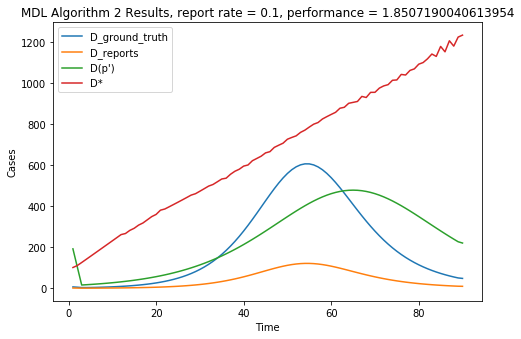

In [20]:
figure = plt.figure(figsize = (7.68,5.12))
plt.plot(XData, YCases, label='D_ground_truth')
plt.plot(XData, YReports/0.5, label='D_reports')
plt.plot(XData, Result_pp[:len(YCases)]+Result_pp[len(YCases):2*len(YCases)], label='D(p\')')
plt.plot(XData, D, label='D*')
plt.xlabel('Time')
plt.ylabel('Cases')
plt.title("MDL Algorithm 2 Results, report rate = " + str(ALPHA) + ", performance = " + str(np.linalg.norm(D-YCases)/np.linalg.norm(YCases)))
plt.legend()
plt.savefig('Result/final.png')
plt.show()
